# 1. Data Preparing: LOTUS Natural Products 

#### Exporting NP data from mongo database of LOTUS

- 要运行该段代码，需要在本地加载LOTUS的mongo数据库
- LOTUS版本：LOTUS version from February 2021

In [ ]:
# connecting and acquring data
import pandas as pd
import pymongo
from pymongo.mongo_client import MongoClient

conn = MongoClient('localhost', port=27017)
db = conn['lotus']
col = db['lotusUniqueNaturalProduct']

lotus = col.find({},{'_id':False, 'lotus_id':1, 'smiles':1, 'inchikey':1,
                        'chemicalTaxonomyNPclassifierPathway':1,
                        'chemicalTaxonomyNPclassifierSuperclass':1,
                        'chemicalTaxonomyNPclassifierClass':1})
lotus = pd.DataFrame(lotus)
conn.close()

lotus.rename(columns={'chemicalTaxonomyNPclassifierPathway': 'pathway',
                      'chemicalTaxonomyNPclassifierSuperclass': 'superclass',
                      'chemicalTaxonomyNPclassifierClass': 'class'}, inplace=True)


In [ ]:
# wash class info
# lotus.fillna('',inplace=True)
lotus['pathway']    = lotus['pathway'].str.split(pat='|', n=1, expand=True)[0]
lotus['superclass'] = lotus['superclass'].str.split(pat='|', n=1, expand=True)[0]
lotus['class']      = lotus['class'].str.split(pat='|', n=1, expand=True)[0]

lotus['connection_status_npclass'] = -1
lotus['connection_status_pubchem'] = -1

# save data
import sqlite3
conn = sqlite3.connect('../data/LOTUS_NP.db')
lotus.to_sql('lotusNP', conn, if_exists='replace', index=False)
conn.close()

## 1.2 从SQLite中读取lotus记录，并填补结构类型的空白

In [ ]:
# NP classfier washing

import json
import urllib3

import sqlite3
conn = sqlite3.connect('../data/LOTUS_NP.db')

# 获取pathway为''、且没有被更新过的记录
# values = conn.execute('SELECT * FROM lotusNP WHERE  pathway = "" AND connection_status_npclass != 200').fetchall()
# SELECT * FROM lotusNP WHERE  (pathway IS NULL OR pathway = '') AND connection_status_npclass !=200
values = conn.execute('SELECT * FROM lotusNP WHERE  pathway IS NULL OR pathway = ""').fetchall()

http = urllib3.PoolManager()
url = 'https://npclassifier.ucsd.edu/classify?smiles='
table_name = 'lotusNP'

i = 0

print('Total: %d'%len(values))
for entry in values:
    i += 1
    smiles = entry[1].replace('%', '%25').replace('+', '%2B').replace('#', '%23').replace('/','%2F')

    try:
        response = http.request('GET', url + smiles, timeout = 5)
    except Exception as e:
        tmp = conn.execute(f'UPDATE {table_name} SET connection_status_npclass = {response.status} WHERE lotus_id = "{entry[0]}"')
            # execute赋给变量，可以阻止直接打印结果
        continue

    if response.status == 200:
        infor = json.loads(response.data.decode('utf-8'))            		
        npClass      = infor['class_results'][0]        if len(infor['class_results']) > 0      else ''
        npSuperclass = infor['superclass_results'][0]   if len(infor['superclass_results']) > 0 else ''
        npPathway    = infor['pathway_results'][0]      if len(infor['pathway_results']) > 0    else ''
        sql = f'UPDATE {table_name} SET '
        sql += f'connection_status_npclass = 200, pathway = "{npPathway}", superclass = "{npSuperclass}", class = "{npClass}" ' 
        sql += f'WHERE lotus_id = "{entry[0]}"'     
        # tmp = cur.execute(sql)
        conn.execute(sql)
    else:
        sql = f'UPDATE {table_name} SET connection_status_npclass = {response.status} WHERE lotus_id = "{entry[0]}"'
        tmp = conn.execute(sql)
    
    if i%50 == 0:
        conn.commit() # 更新数据库

    print(f'index (%d): %s || is accomplished, %.2f%% accomplished.'%(i, entry[0], 100*i/len(values)), flush=True, end='\r')

conn.commit() # 更新数据库
conn.close()


## 1.3 Structural class count

In [6]:
import pandas as pd
import sqlite3
conn = sqlite3.connect('../data/iNP.db')

lotus = pd.read_sql('SELECT * FROM lotusNP', conn)
lotus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276518 entries, 0 to 276517
Data columns (total 8 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   lotus_id                   276518 non-null  object
 1   smiles                     276518 non-null  object
 2   inchikey                   276518 non-null  object
 3   pathway                    276518 non-null  object
 4   superclass                 276518 non-null  object
 5   class                      276518 non-null  object
 6   connection_status_npclass  276518 non-null  int64 
 7   connection_status_pubchem  276518 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 16.9+ MB


In [7]:
lotus['pathway'] = lotus['pathway'].str.replace(r'^\s*$', 'Other', regex=True)

In [8]:
data = lotus['pathway'].value_counts().reset_index()
data = pd.DataFrame(data)
data

,pathway,count
0,Terpenoids,128700
1,Shikimates and Phenylpropanoids,50613
2,Alkaloids,32634
3,Polyketides,31971
4,Fatty acids,13698
5,Amino acids and Peptides,12698
6,Other,3405
7,Carbohydrates,2799


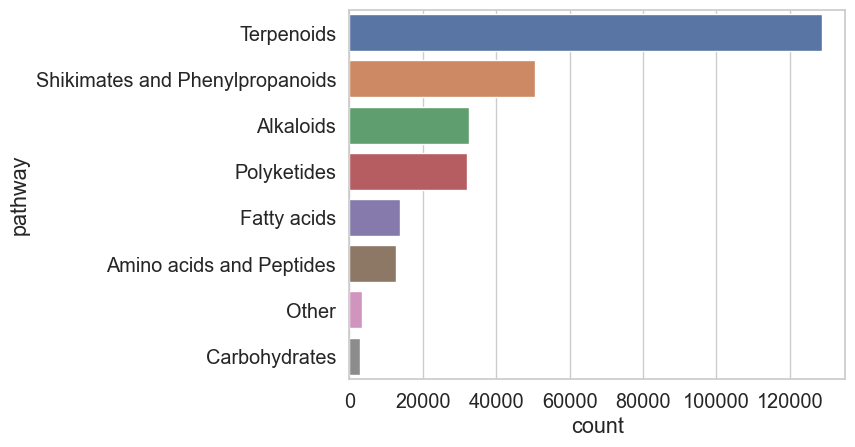

In [9]:
import seaborn as sns
sns.set_theme(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1.3)
fig = sns.barplot(x="count", y="pathway", data=data,alpha=1.0)
fig.figure.savefig('../plot/1-NP_class_count.svg', transparent=True)